In [1]:
import os
import dateparser
import pandas as pd
import json
import nltk
import numpy as np
import string
import re
import csv
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from functions import load_data_tagtog, query_dataframe, load_data
from functions import *
import dateparser
from fuzzysearch import find_near_matches

In [2]:
df_data = load_data_tagtog(['../tagtog/output']).fillna('')
df_data = df_data.loc[df_data['is_flood'].astype(bool)]

### Apply all functions

In [8]:
# 2723 - old data
# 3464 - new data
# 3074 - new new data
override=False
if not override and os.path.exists('timeseries_data/all_data/all_isFlood.json'):
    df_data = pd.read_json('timeseries_data/all_data/all_isFlood.json')
else:
    df_data = add_prev_true_data(df_data)
    df_data = add_newspapers(df_data)
    df_data = add_datePublished(df_data)
    df_data = add_location(df_data)
    df_data = df_data[df_data['divisions'].apply(lambda x:len(x)>0)]
    json.dump(json.loads(df_data.to_json(orient='records')), open('timeseries_data/all_data/all_isFlood.json','w'), indent=2)
df_data.head()

,doc_id,filename,text,is_flood,is_bangladesh,flood_related,flood_climatechange,newspaper,flood_type,dates,...,event_damage-people_affected,event_damage-peopled_displaced,event_damage-homes_affected,event_damage-disease,event_damage-fatalities,event_dates,event_dates-date,event_dates-prev_date,datePublished,connect_filename
0,ec583817-3c60-41ee-b856-65f0d9bd7772,dailySun_data_ec583817-3c60-41ee-b856-65f0d9bd...,Date Published:2017-08-31 06:03:11+00:00 tuesd...,True,,,,dailySun,,[],...,[],[],[],[],[],[],[],[],2017-08-31 06:03:11+00:00,
1,f4806621-b874-4f20-97fb-f7c1fa94f6bc,theDailyStar_data_f4806621-b874-4f20-97fb-f7c1...,Date Published:2016-05-05 00:00:00 Flash flood...,True,True,True,False,theDailyStar,flash,[],...,[],[],[],[],[],[],[],[],2016-05-05 00:00:00,
2,259d503d-f6b1-44b6-a866-8eff03799a07,prothomalo_data_259d503d-f6b1-44b6-a866-8eff03...,Date Published:None Flood situation worsened f...,True,,,,prothomalo,,[],...,[],[],[],[],[],[],[],[],2019-07-17T03:35:13Z,
3,1e8c824c-6142-496e-ab4b-aeefaeedc681,theIndependent_data_1e8c824c-6142-496e-ab4b-ae...,Date Published:2016-06-04 10:27:51 Rail commun...,True,,,,theIndependent,,[],...,[],[],[],[],[],[],[],[],2016-06-04 10:27:51,
4,7c2bc791-c162-46bf-9224-2686d6798c33,dailySun_data_7c2bc791-c162-46bf-9224-2686d679...,Date Published:2019-09-30 13:44:33+00:00 tuesd...,True,,,,dailySun,,[],...,[],[],[],[],[],[],[],[],2019-09-30 13:44:33+00:00,


In [10]:
def upload_data(data, upload_folder, n=1000):
    if not os.path.isdir(upload_folder): os.mkdir(upload_folder)
    for row in data.sample(n=n, random_state=32).iterrows():
        iid = row[1]['doc_id']
        newspaper = row[1]['newspaper']
        filename = '{}_data_{}@.txt'.format(newspaper, iid)
        text = row[1]['text'] + '\n@#@'
        open(os.path.join(upload_folder, filename),'w').write(text)
# upload_data(df_data[df_data['is_flood']==True], 'upload-flood', 200)

In [11]:
def plot_year_yearmonth(df, main_title='', save_file=None):
    dates_all = query_dataframe(df,{'is_flood':True})['datePublished']
    yearPublished_count_list, yearPublished_month_count_list,_ = date_counts(parse_all_dates(dates_all))

    yearPublished_month_count_list_2007 = get_month_range(yearPublished_month_count_list, year_range=[None,2007])
    yearPublished_month_count_list_2014 = get_month_range(yearPublished_month_count_list, year_range=[2008,2014])
    yearPublished_month_count_list_2020 = get_month_range(yearPublished_month_count_list, year_range=[2015,None])
    
    if save_file:
        yearPublished = {i[0]:i[1] for i in yearPublished_count_list}
        ym_yearPublished2007 = {i[0]:i[1] for i in yearPublished_month_count_list_2007}
        ym_yearPublished2014 = {i[0]:i[1] for i in yearPublished_month_count_list_2014}
        ym_yearPublished2020 = {i[0]:i[1] for i in yearPublished_month_count_list_2020}
        yearMonthPublished = ym_yearPublished2007
        for k,v in ym_yearPublished2014.items(): yearMonthPublished[k]=v
        for k,v in ym_yearPublished2020.items(): yearMonthPublished[k]=v   
        data = {'yearPublished':yearPublished,  
                'yearMonthPublished':yearMonthPublished}
        json.dump(data, open(save_file, 'w'), indent=2)

    plot_timeseries([
        {'count_list': yearPublished_count_list, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year Counts', 'Year', 'Year Counts', True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2007, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2007', 'Year-Month', 
        'Year-Month Counts', True, True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2014, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2014', 'Year-Month', 
        'Year-Month Counts', True, True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2020, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2020', 'Year-Month', 
        'Year-Month Counts', True, True)


In [12]:
def get_articles_df(df_data, query_key, query_terms):
    new_df = None
    if type(query_terms)==str: query_terms = [query_terms]
    for d in query_terms:
        temp_df = df_data[df_data[query_key].apply(lambda x: d in x)]
        if new_df is None: new_df = temp_df
        else: new_df = pd.concat([new_df, temp_df])
    return new_df

def get_division_articles(df_data, divisions):
    return get_articles_df(df_data, 'divisions', divisions)

def get_district_articles(df_data, districts):
    return get_articles_df(df_data, 'districts', districts)

def get_newspaper_articles(df_data, newspapers):
    return get_articles_df(df_data, 'newspaper', newspapers)

In [13]:
# rajshahi_articles = get_division_articles(df_data, 'rajshahi')
# open('rajshahi-2019-10.txt','w').write('\n\n-----------------------------------------------\n\n'
#            .join(list(rajshahi_articles[rajshahi_articles['datePublished']
#                                         .str.contains('2019-10')]['text'])))
                                       

### Year Published daily distribution

In [14]:
def get_yearly_data(df, save_file):
    dates_all = query_dataframe(df,{'is_flood':True})['datePublished']
    yearPublished_count_list, yearPublished_month_count_list, yearPublished_month_day_count_list = date_counts(parse_all_dates(dates_all))
    yearPublished_month_day_count_list = complete_day(yearPublished_month_day_count_list, year_range=[None, None])

    yearMonthDayPublished = {i[0]:i[1] for i in yearPublished_month_day_count_list}
    json.dump(yearMonthDayPublished, open(save_file, 'w'), indent=2)

get_yearly_data(df_data, 'timeseries_data/yearPublished_day/yearPublished_day.json')

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

In [15]:
get_yearly_data(get_division_articles(df_data,'sylhet'), 'timeseries_data/yearPublished_day/yearPublished_day_sylhet.json')
get_yearly_data(get_division_articles(df_data,'chattogram'), 'timeseries_data/yearPublished_day/yearPublished_day_chattogram.json')
get_yearly_data(get_division_articles(df_data,'dhaka'), 'timeseries_data/yearPublished_day/yearPublished_day_dhaka.json')
get_yearly_data(get_division_articles(df_data,'rangpur'), 'timeseries_data/yearPublished_day/yearPublished_day_rangpur.json')
get_yearly_data(get_division_articles(df_data,'rajshahi'), 'timeseries_data/yearPublished_day/yearPublished_day_rajshahi.json')
get_yearly_data(get_division_articles(df_data,'khulna'), 'timeseries_data/yearPublished_day/yearPublished_day_khulna.json')
get_yearly_data(get_division_articles(df_data,'barishal'), 'timeseries_data/yearPublished_day/yearPublished_day_barishal.json')
get_yearly_data(get_division_articles(df_data,'mymensingh'), 'timeseries_data/yearPublished_day/yearPublished_day_mymensingh.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

## YearPublished daily distribution by newspaper

In [16]:
set(list(df_data['newspaper']))

{'bdnews',
 'dailyObserver',
 'dailySun',
 'dhakaTribune',
 'newAge',
 'nytimes',
 'prothomalo',
 'theDailyStar',
 'theIndependent',
 'theNewNation',
 'thedailystar'}

In [17]:
get_yearly_data(get_newspaper_articles(df_data,'bdnews'), 
                'timeseries_data/yearPublished_day_newspaper/bdnews.json')
get_yearly_data(get_newspaper_articles(df_data,'dailyObserver'), 
                'timeseries_data/yearPublished_day_newspaper/dailyObserver.json')
get_yearly_data(get_newspaper_articles(df_data,'dailySun'), 
                'timeseries_data/yearPublished_day_newspaper/dailySun.json')
get_yearly_data(get_newspaper_articles(df_data,'dhakaTribune'), 
                'timeseries_data/yearPublished_day_newspaper/dhakaTribune.json')
get_yearly_data(get_newspaper_articles(df_data,'newAge'), 
                'timeseries_data/yearPublished_day_newspaper/newAge.json')
get_yearly_data(get_newspaper_articles(df_data,'nytimes'), 
                'timeseries_data/yearPublished_day_newspaper/nytimes.json')
get_yearly_data(get_newspaper_articles(df_data,'prothomalo'), 
                'timeseries_data/yearPublished_day_newspaper/prothomalo.json')
get_yearly_data(get_newspaper_articles(df_data,'theIndependent'), 
                'timeseries_data/yearPublished_day_newspaper/theIndependent.json')
dailyStarData = pd.concat([get_newspaper_articles(df_data,'thedailystar'), 
                           get_newspaper_articles(df_data,'theDailyStar')])
get_yearly_data(dailyStarData, 'timeseries_data/yearPublished_day_newspaper/theDailyStar.json')

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date 

In [18]:
def plot_timeseries(l, title='', xlabel='', ylabel='', xticks_rotate=False, skip=0):
    plt.figure(figsize=(15, 7))
    colors = ['b', 'r', 'g', 'c','m','y','k','w']
    for i, entry in enumerate(l):
        plot_color = entry.get('color', colors[i])
        if entry.get('type', None) == 'bar':
            plt.bar([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']],
                    color=plot_color, label=entry['label'])
        else:
            plt.plot([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']],
                     linestyle='-', marker='o', color=plot_color, label=entry['label'])
        plt.xticks([i[0] for i in entry['count_list']])

    plt.legend(fontsize=18)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks_rotate: plt.xticks(rotation='vertical')

    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::skip]))
        for label in temp:
            label.set_visible(False)
    plt.show()

In [19]:
def plot_newspapers(newspaper_data_root_folder='timeseries_data/yearPublished_day_newspaper',
                   newspapers=None):
    if not newspapers:
        newspapers = ['bdnews', 'dailyObserver','dailySun','dhakaTribune','newAge',
                      'nytimes','theIndependent','theDailyStar']
    newspaper_plot_input = []
    for np in newspapers:
        news_data = json.load(open(os.path.join(newspaper_data_root_folder,np+'.json')))
        news_data = complete_day([(k,v) for k,v in news_data.items()], year_range=[2015, None], aggType='month')
        newspaper_plot_input.append({'count_list':news_data, 'label': np})
        plot_timeseries(newspaper_plot_input, 
                        'Newspaper: '+np, 'Date', '# Articles', True, skip=3)
        newspaper_plot_input = []

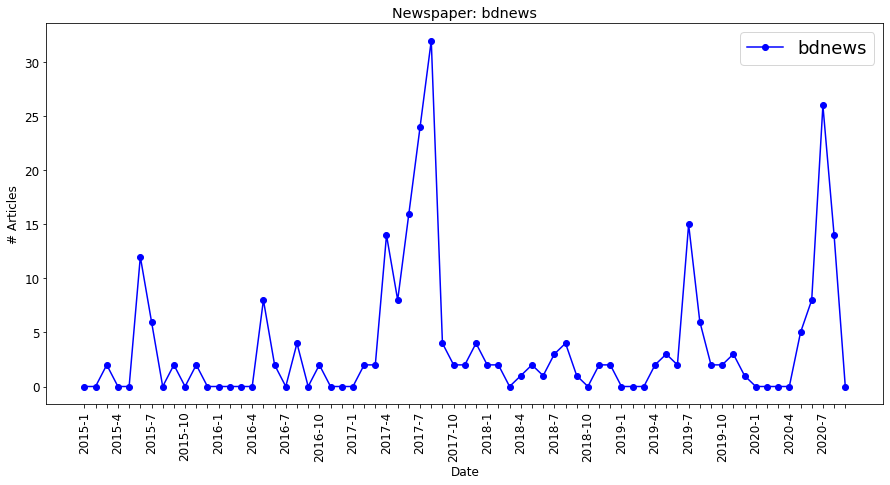

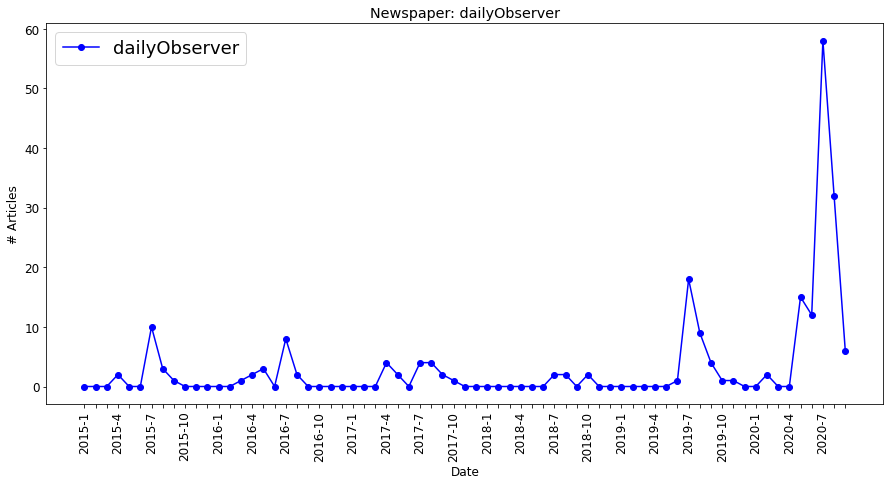

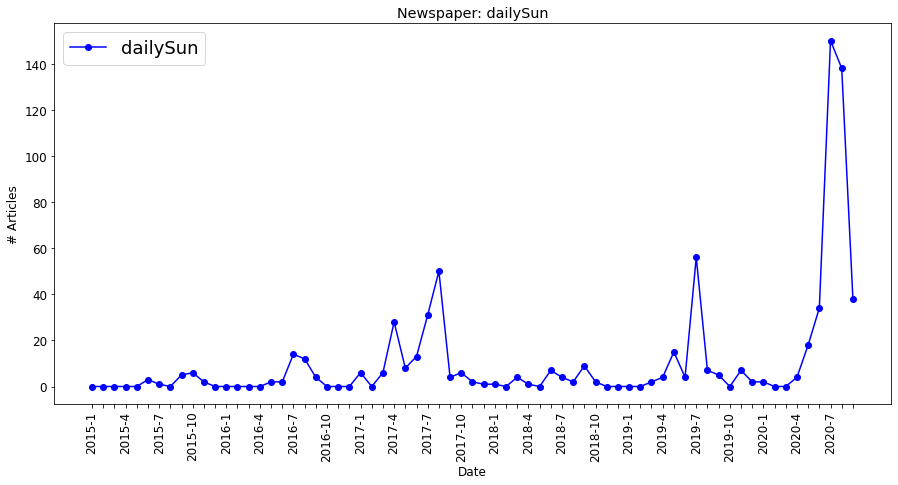

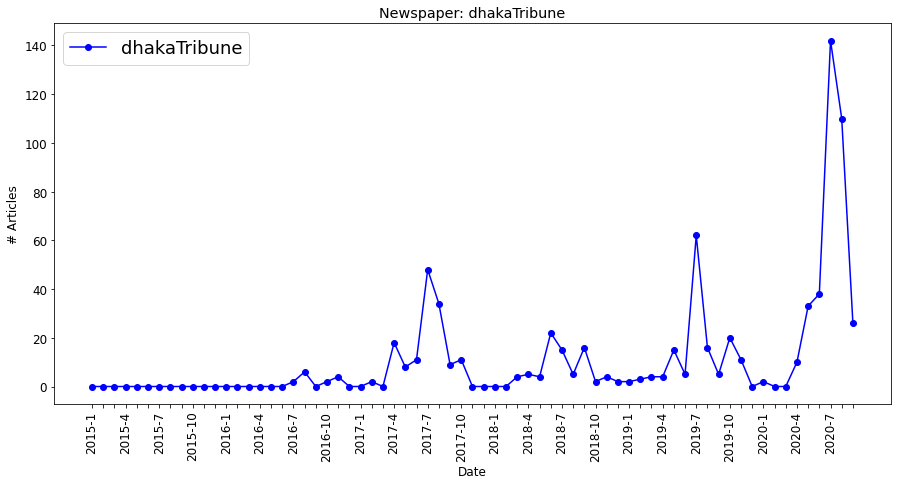

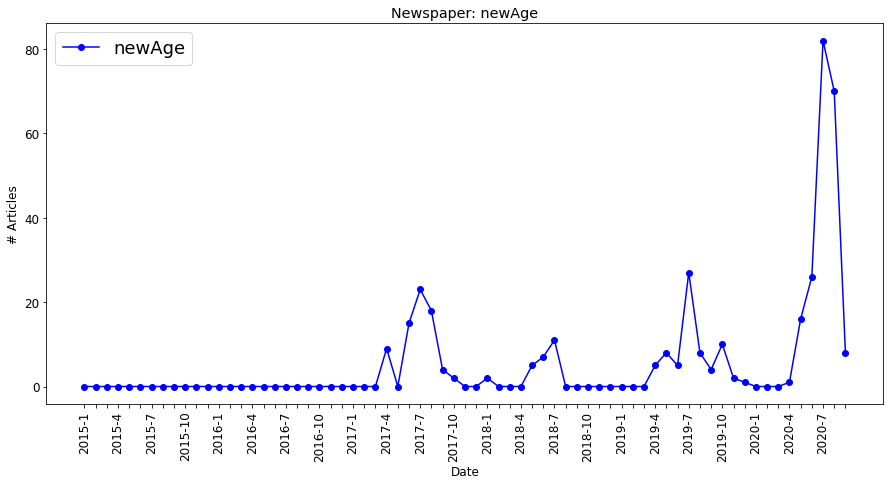

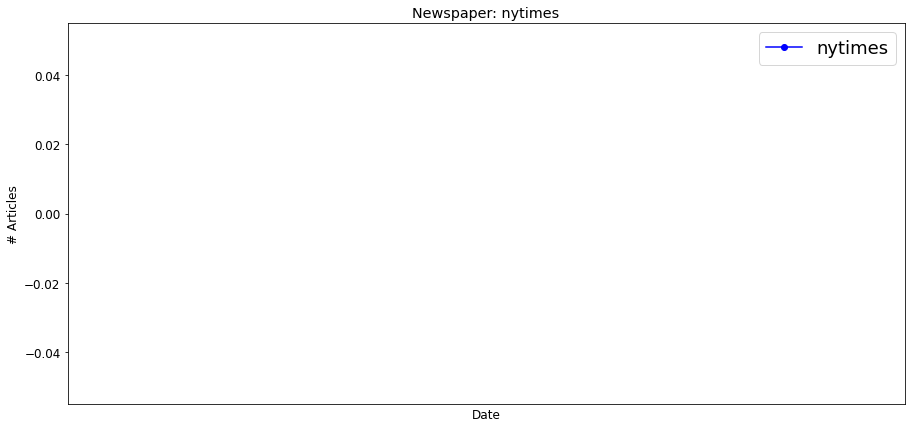

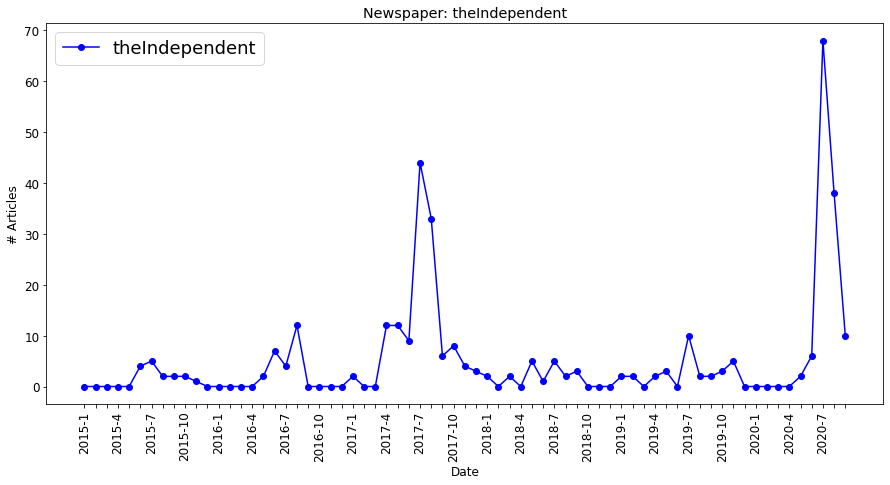

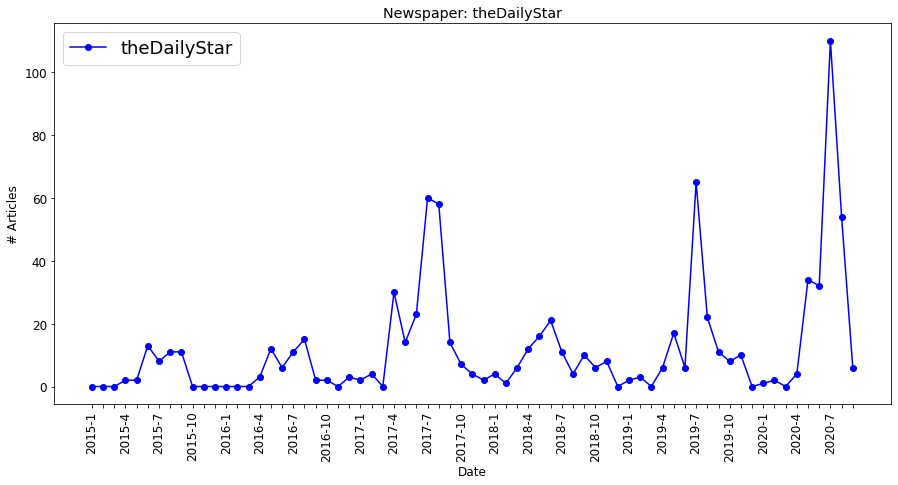

In [20]:
plot_newspapers()

### Timeseries Graphs

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

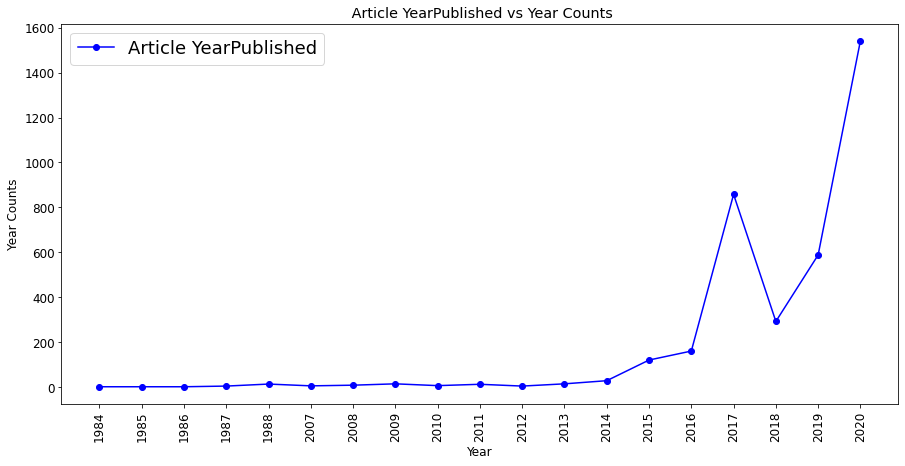

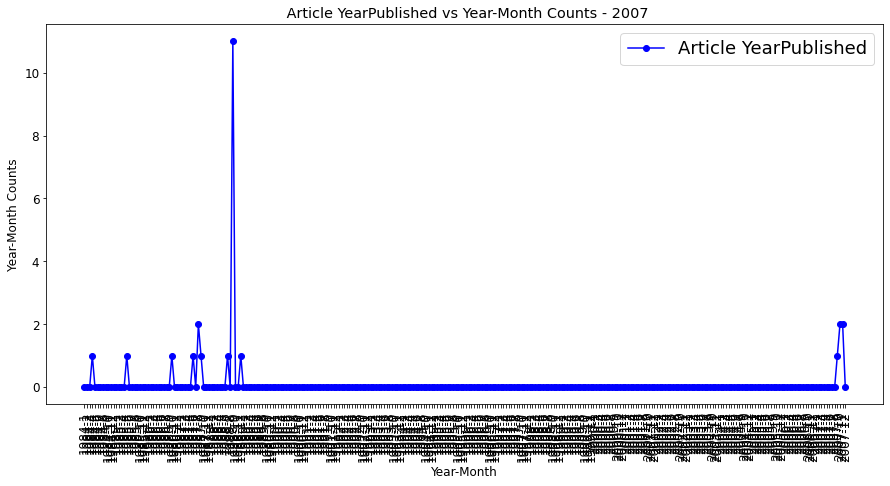

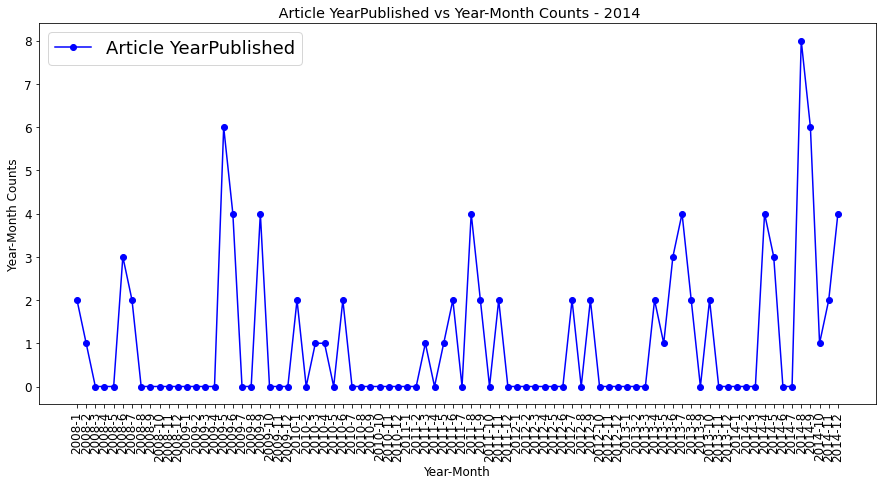

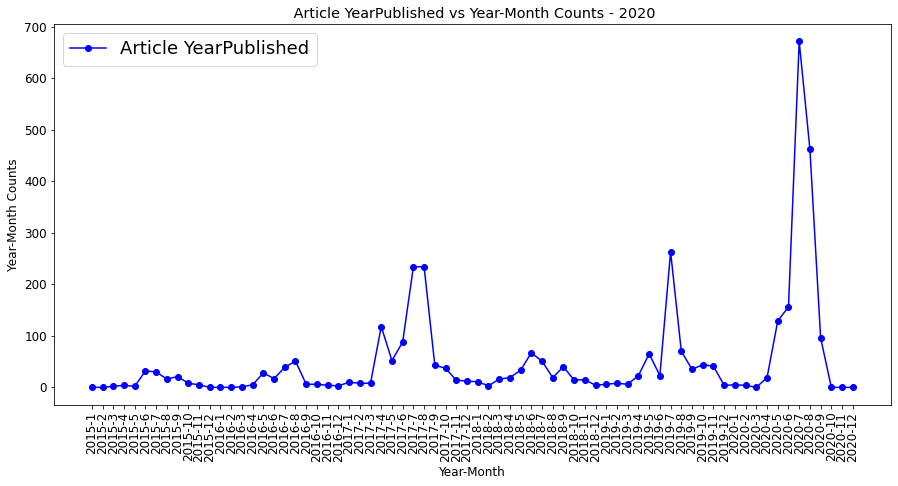

In [21]:
plot_year_yearmonth(df_data, '', 'timeseries_data/yearPublished_year_month/all.json')

In [22]:
dates_all = query_dataframe(df_data,{'is_flood':True})['datePublished']
yearPublished_count_list, yearPublished_month_count_list,_ = date_counts(parse_all_dates(dates_all))

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


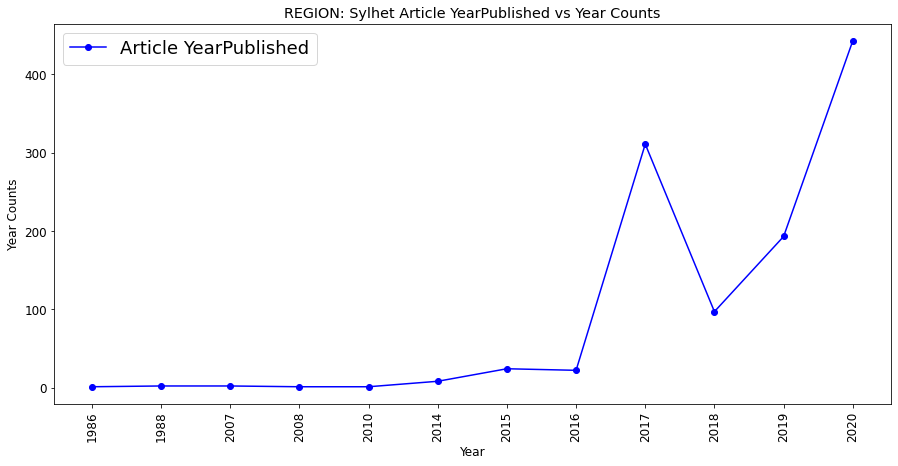

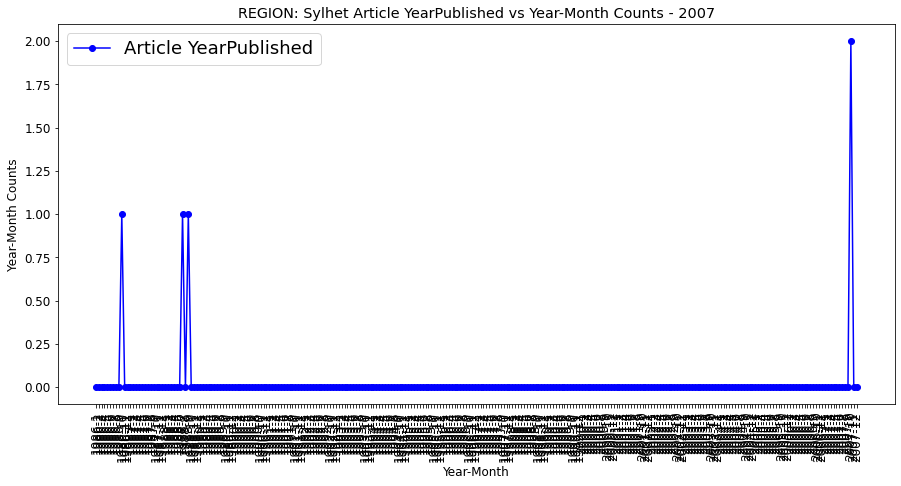

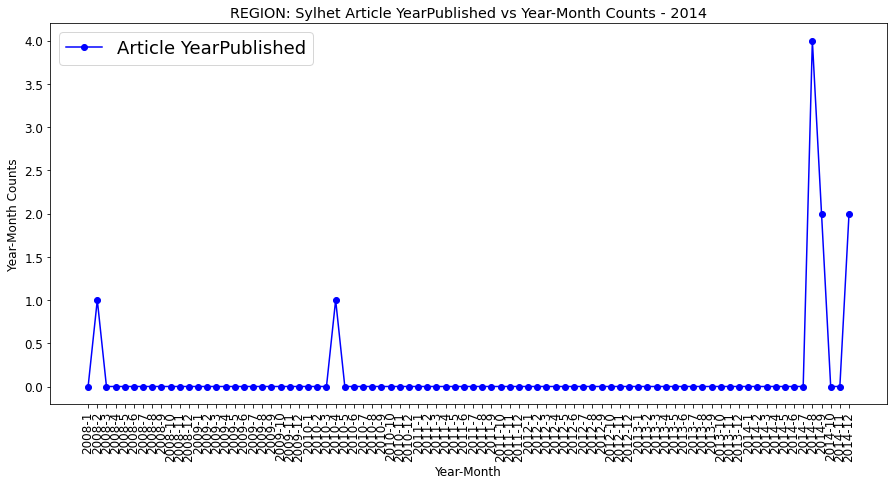

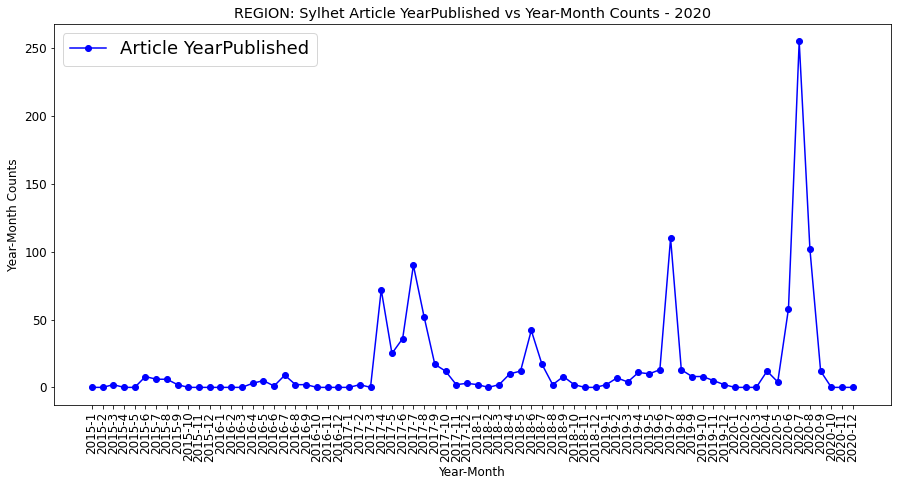

In [23]:
plot_year_yearmonth(get_division_articles(df_data,'sylhet'), 'REGION: Sylhet', 'timeseries_data/yearPublished_year_month/sylhet.json')

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


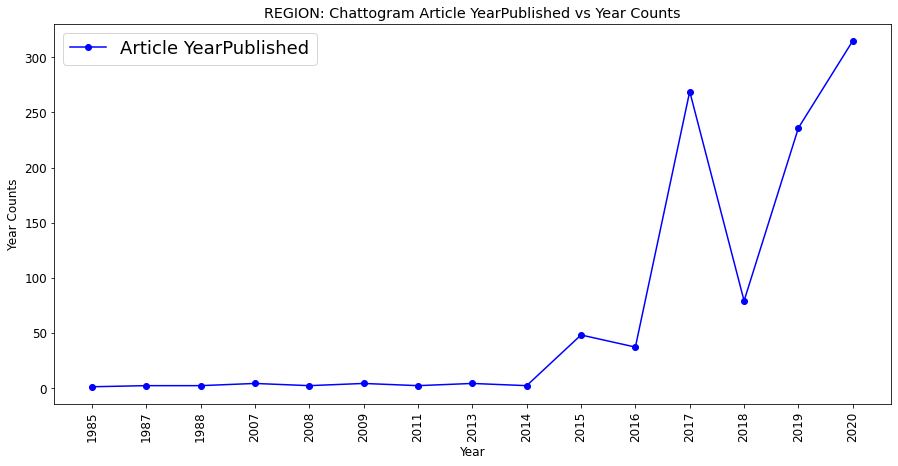

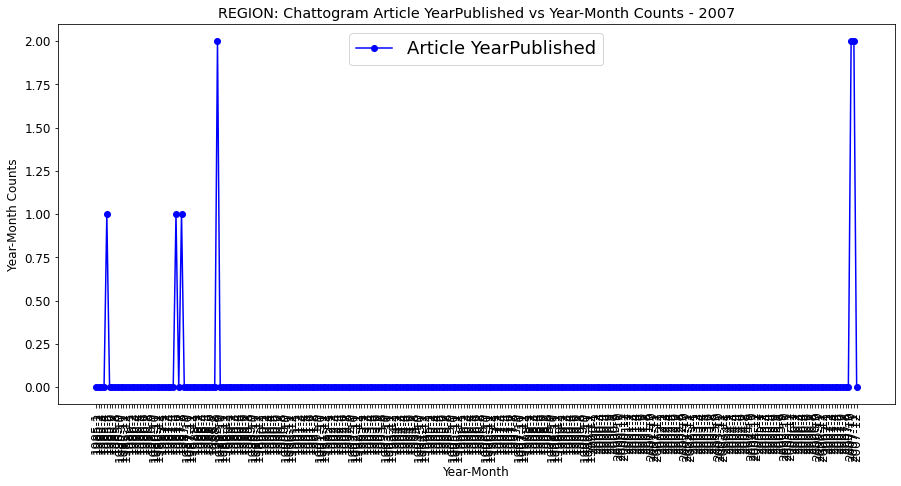

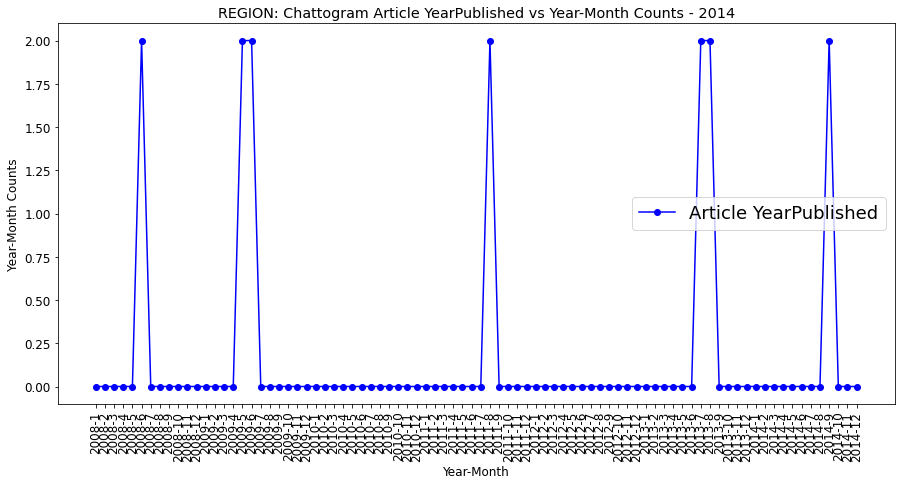

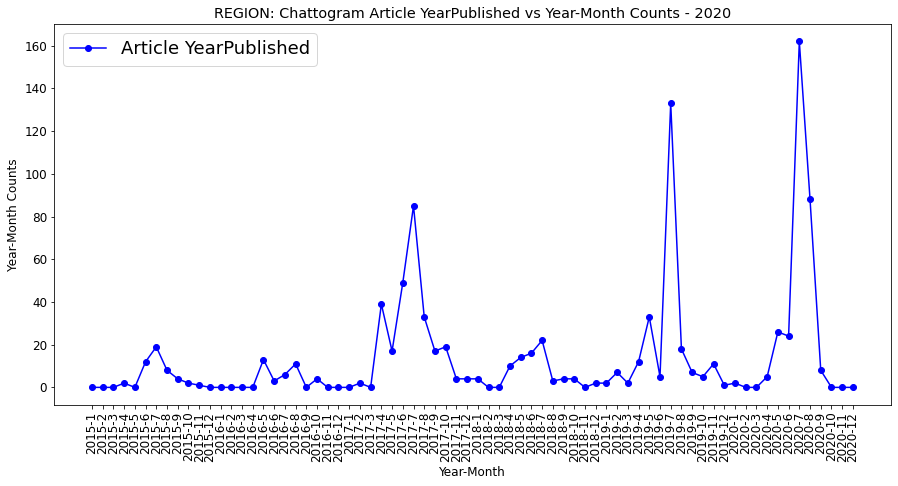

In [24]:
plot_year_yearmonth(get_division_articles(df_data,'chattogram'), 'REGION: Chattogram', 'timeseries_data/yearPublished_year_month/chattogram.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

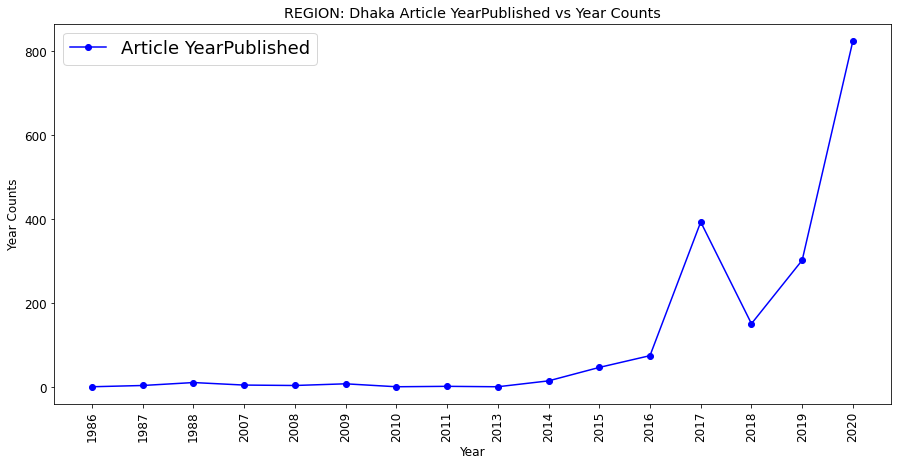

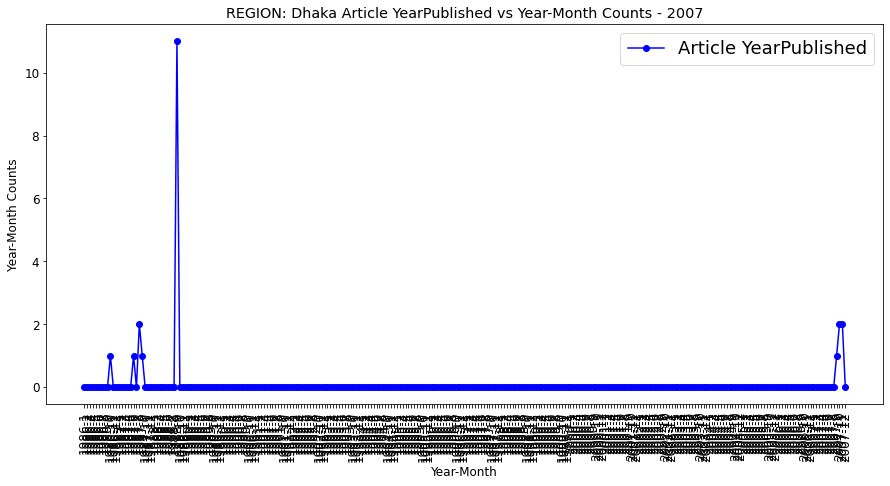

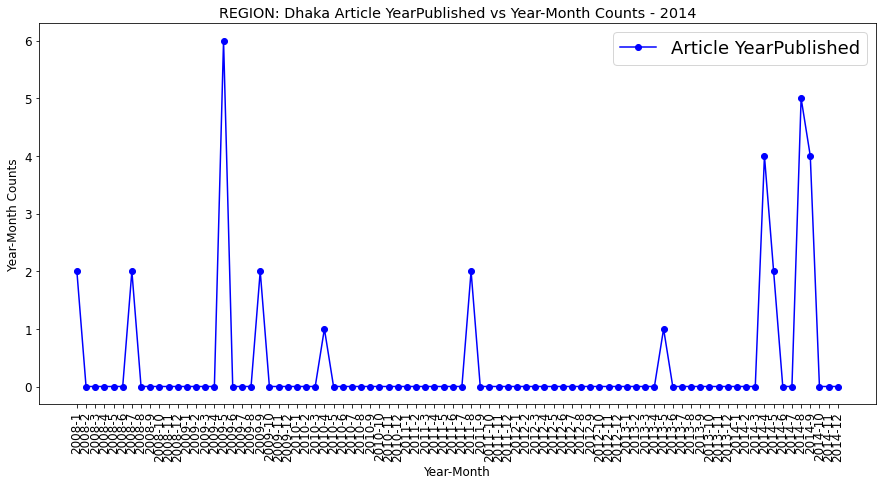

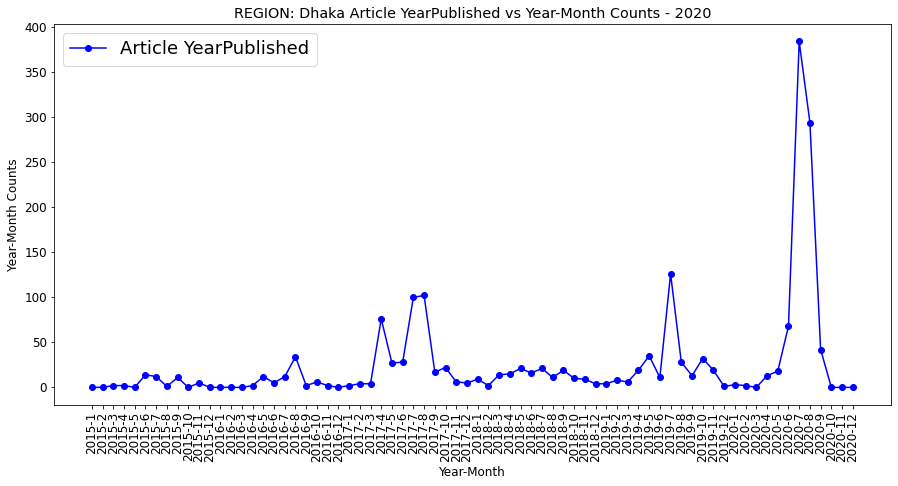

In [25]:
plot_year_yearmonth(get_division_articles(df_data,'dhaka'), 'REGION: Dhaka', 'timeseries_data/yearPublished_year_month/dhaka.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2051-11-13 00:00:00') 2051-11-13 00:00:00
('No Date Present', 'None') None
('No Date Pre

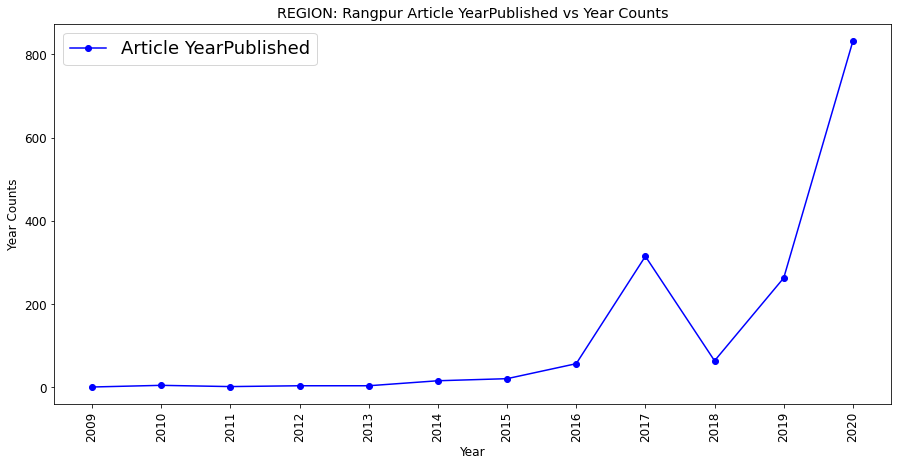

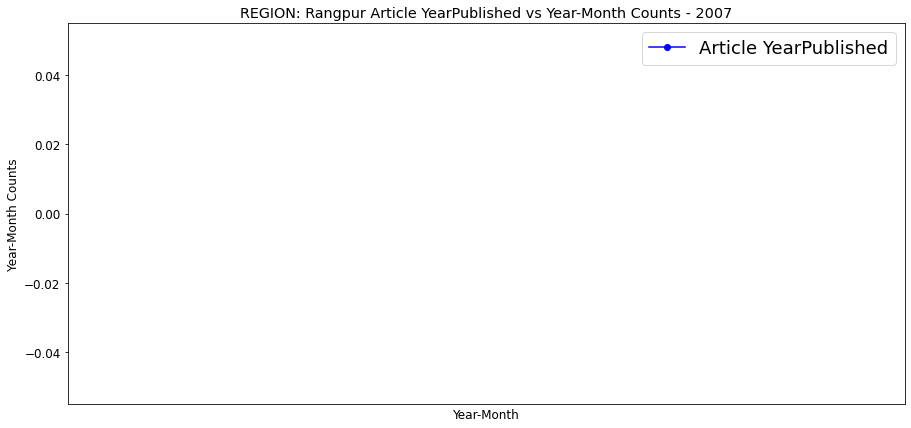

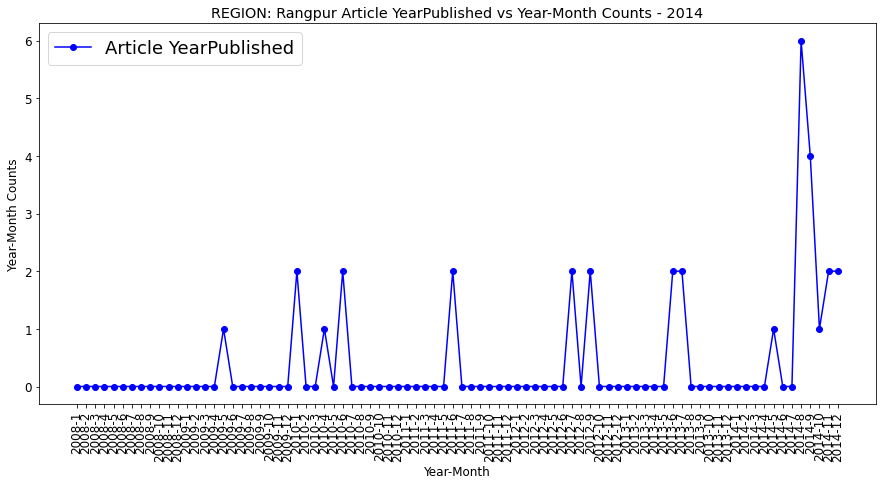

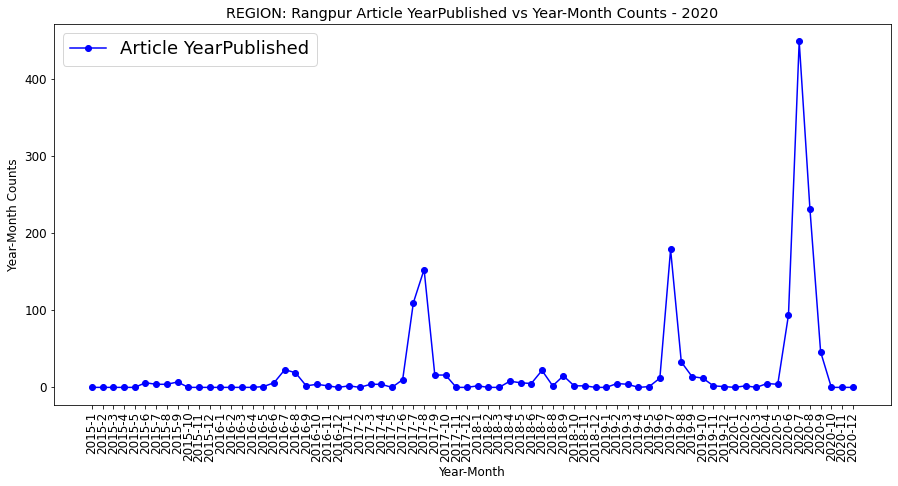

In [26]:
plot_year_yearmonth(get_division_articles(df_data,'rangpur'), 'REGION: Rangpur', 'timeseries_data/yearPublished_year_month/rangpur.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date 

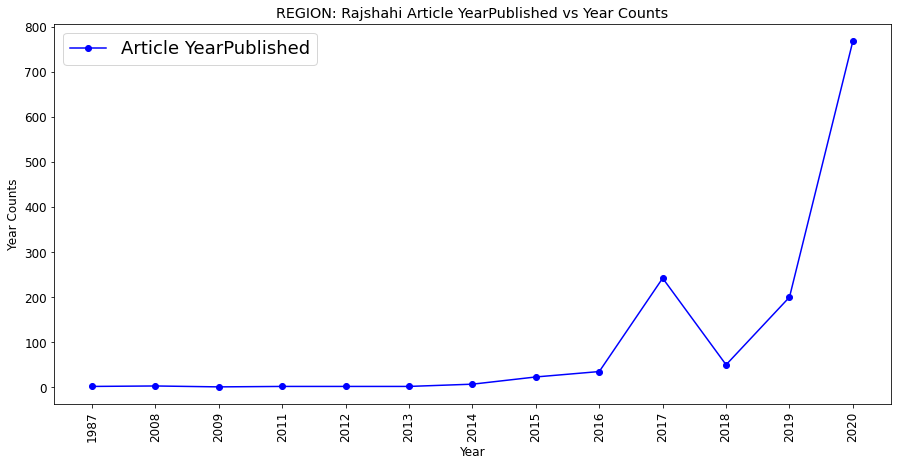

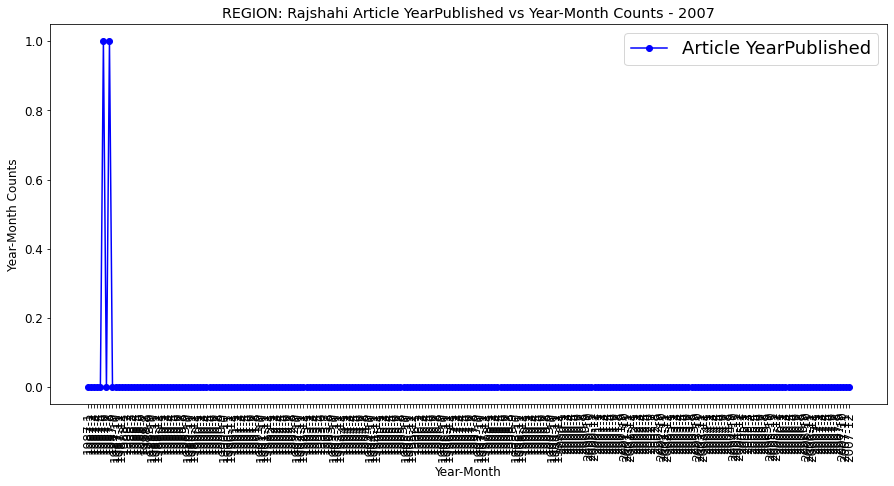

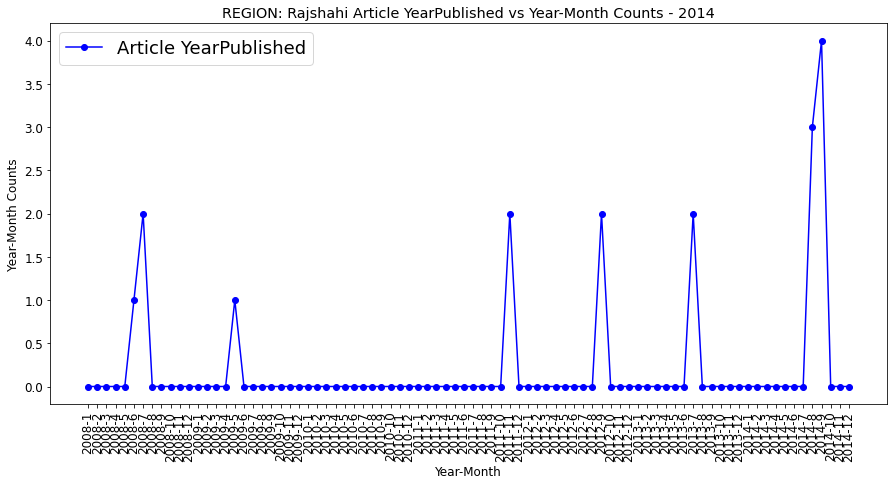

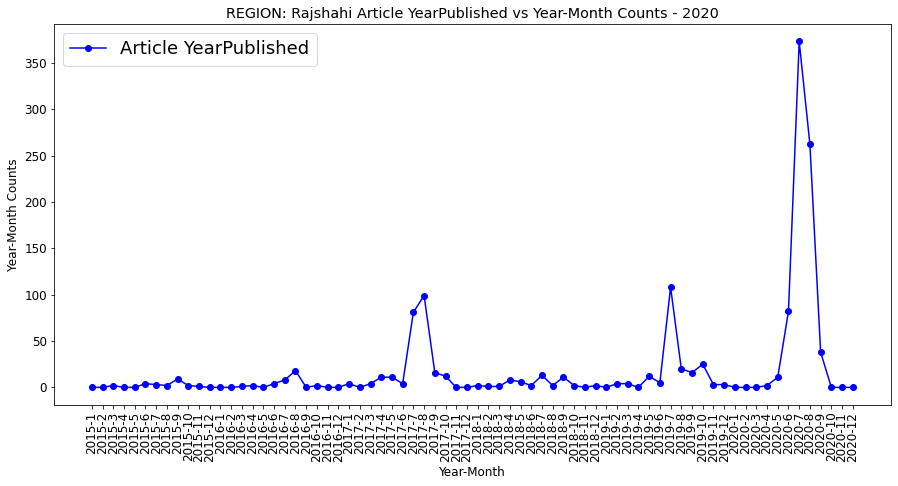

In [27]:
plot_year_yearmonth(get_division_articles(df_data,'rajshahi'), 'REGION: Rajshahi', 'timeseries_data/yearPublished_year_month/rajshahi.json')


('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


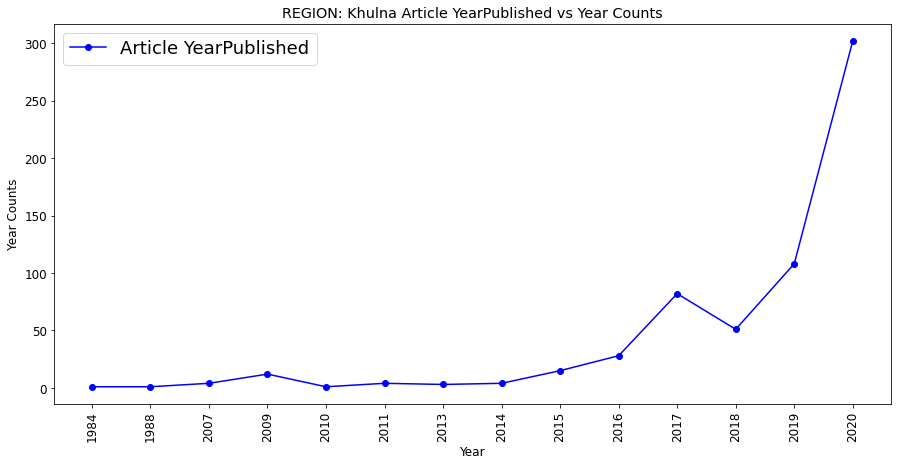

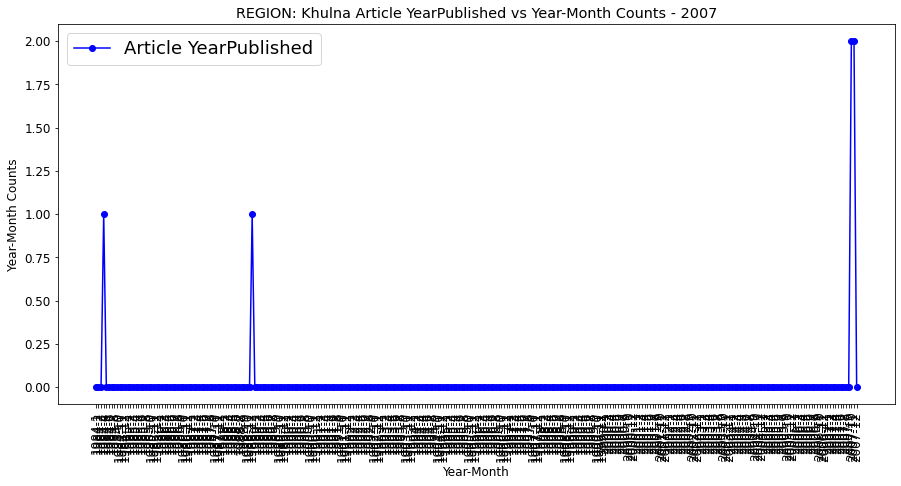

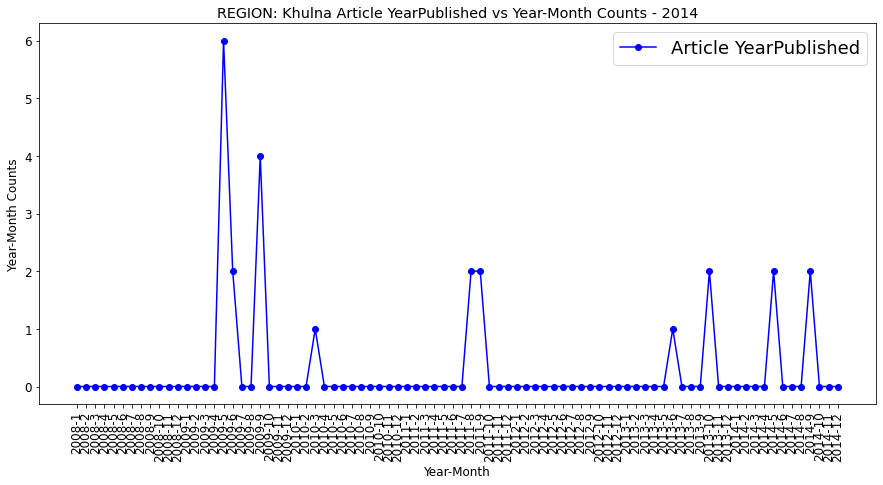

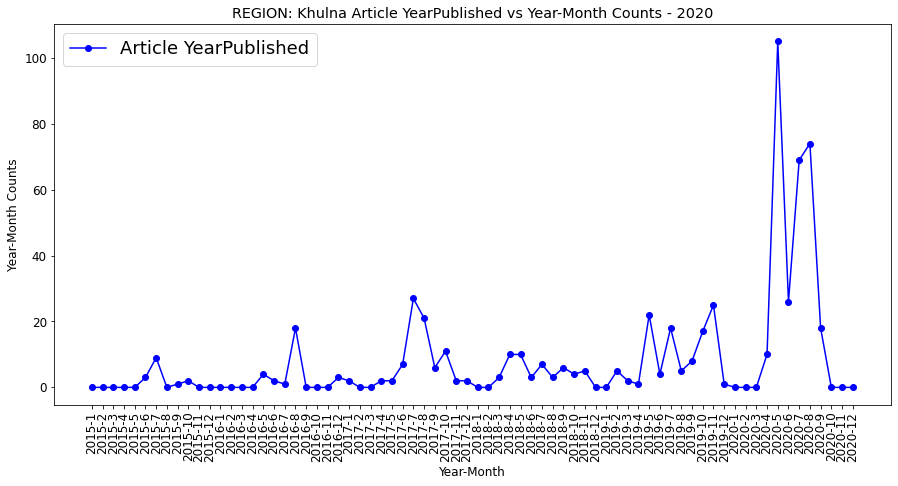

In [28]:
plot_year_yearmonth(get_division_articles(df_data,'khulna'), 'REGION: Khulna', 'timeseries_data/yearPublished_year_month/khulna.json')


('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


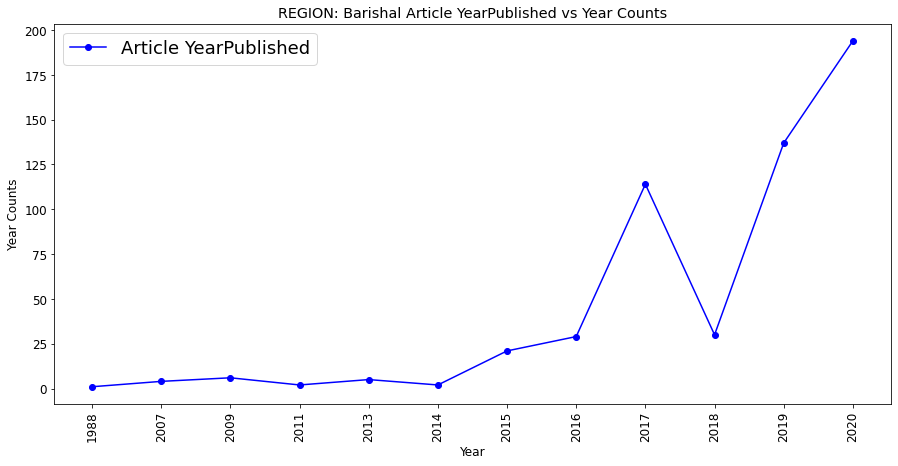

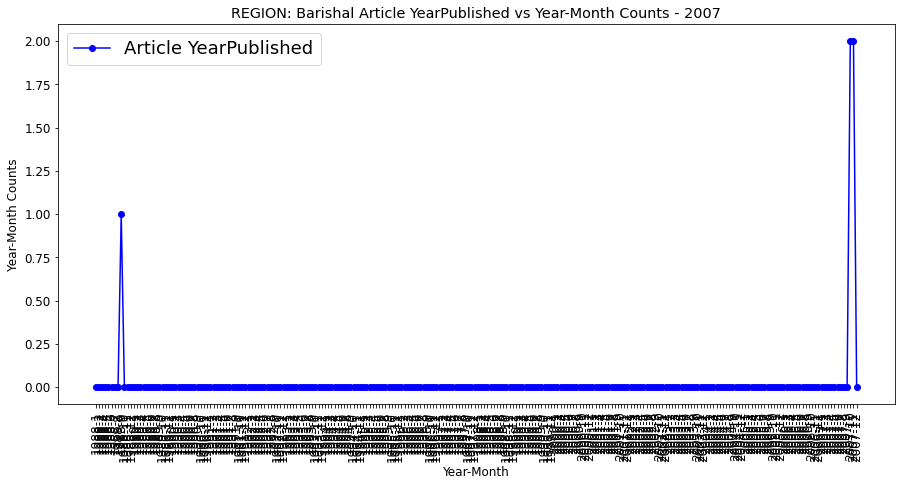

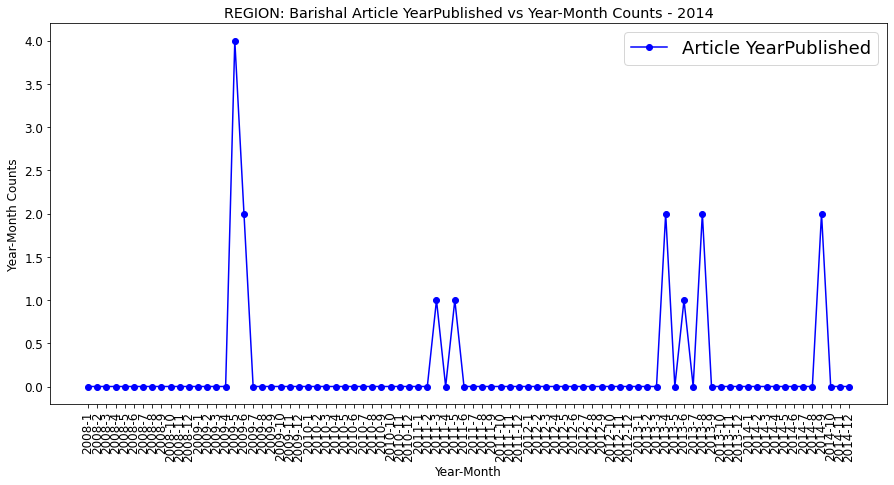

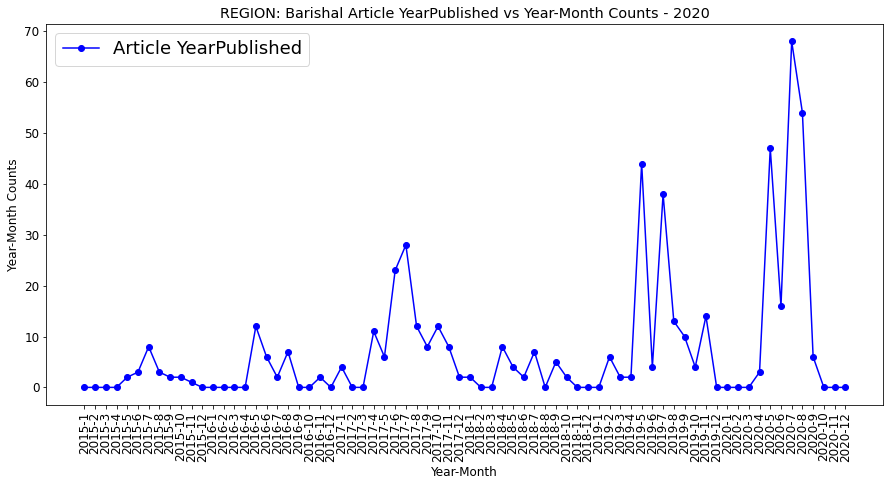

In [29]:
plot_year_yearmonth(get_division_articles(df_data,'barishal'), 'REGION: Barishal','timeseries_data/yearPublished_year_month/barishal.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


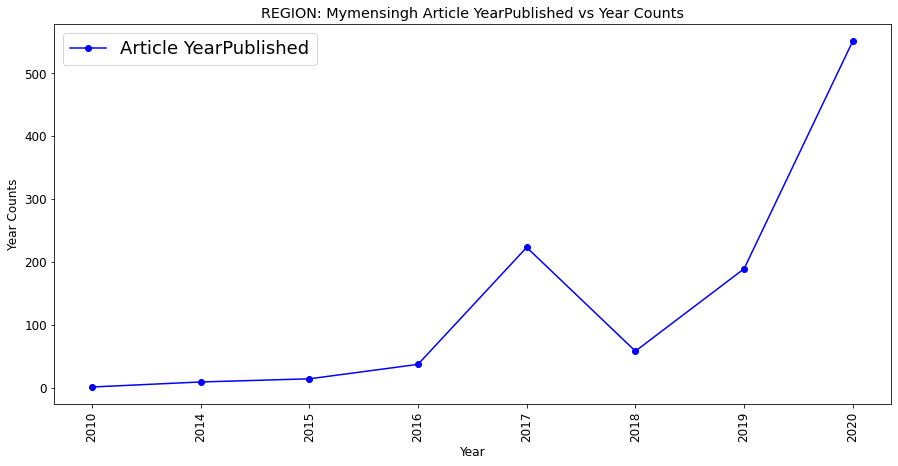

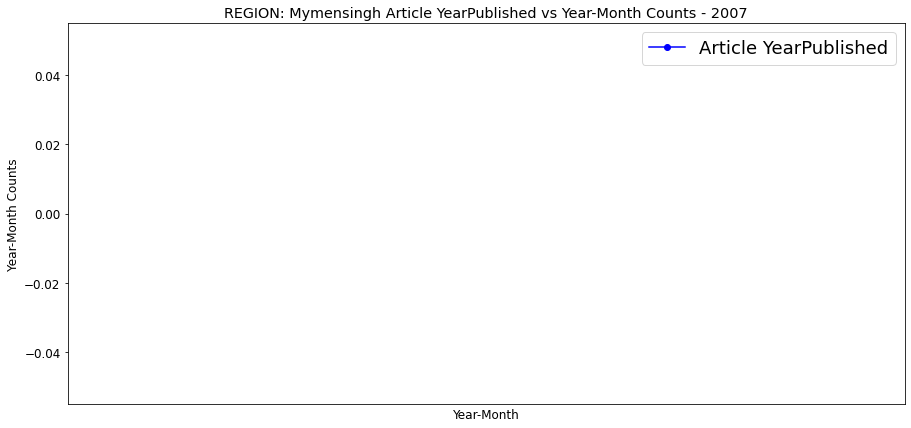

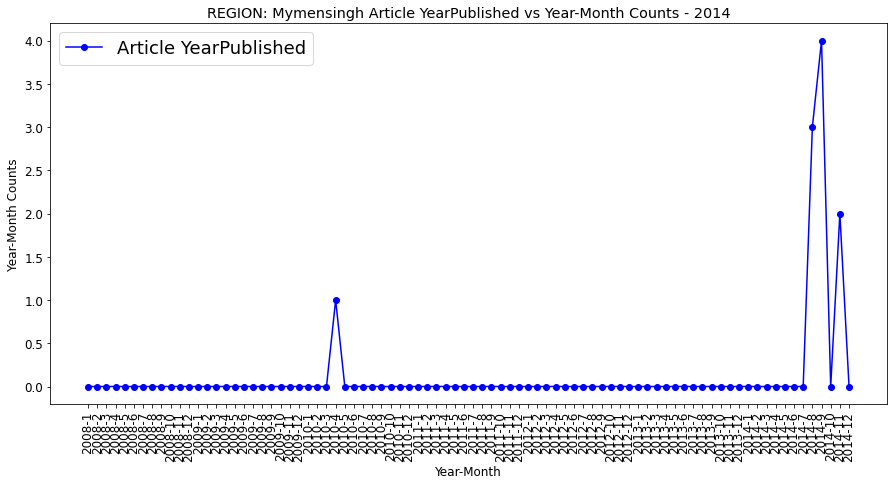

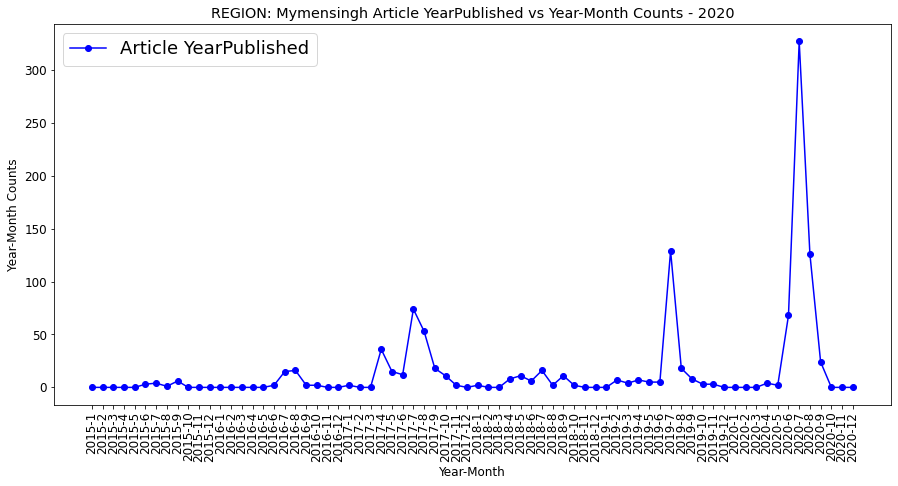

In [30]:
plot_year_yearmonth(get_division_articles(df_data,'mymensingh'), 'REGION: Mymensingh','timeseries_data/yearPublished_year_month/mymensingh.json')


### Newspaper Types

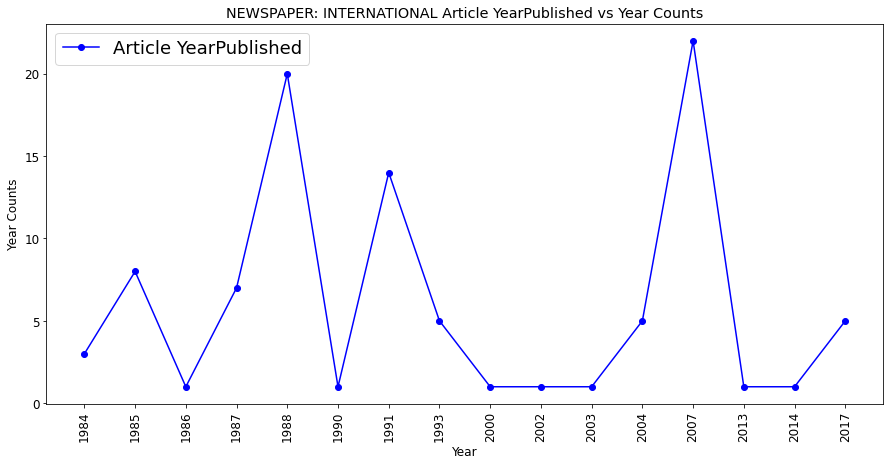

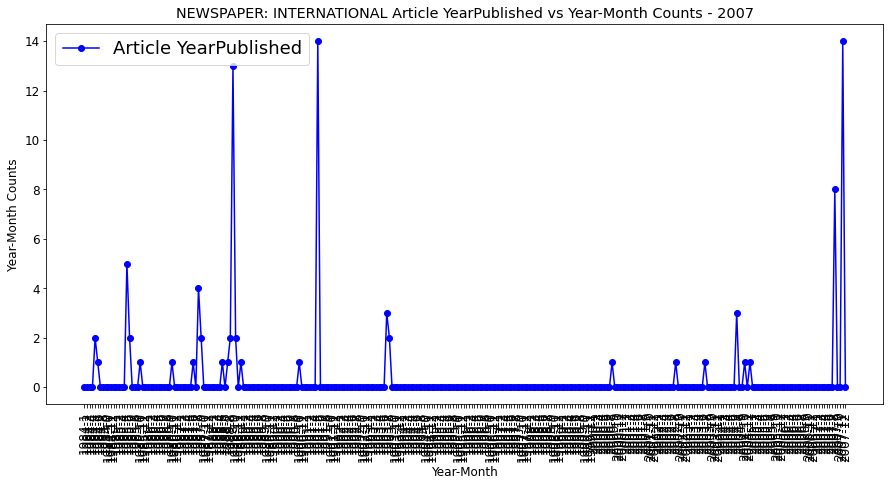

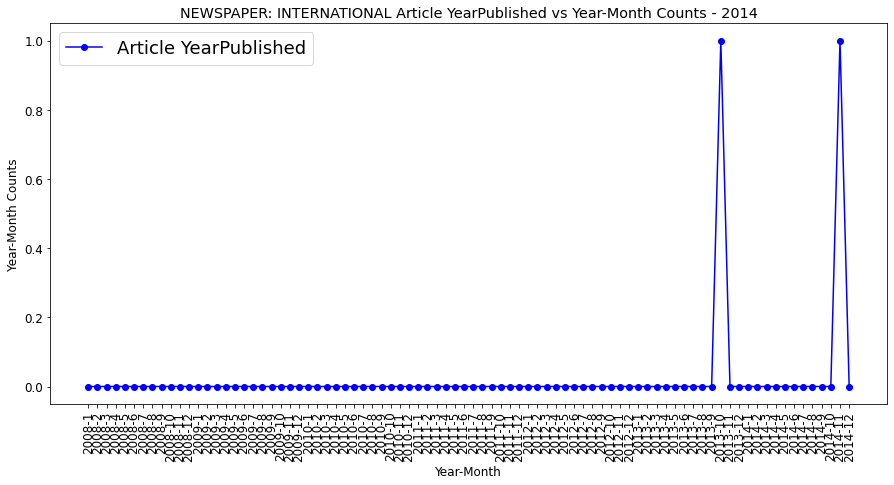

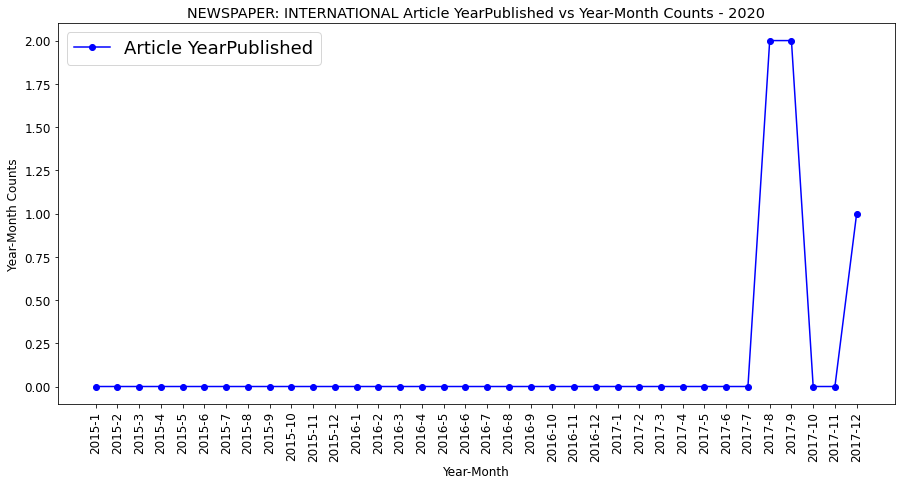

In [19]:
international = ['nytimes']
national = ['thedailystar', 'prothomalo', 'dailySun', 'theIndependent', 'dhakaTribune', 
            'dailyObserver', 'newAge', 'bdnews', 'thedailystar']
plot_year_yearmonth(get_newspaper_articles(df_data, international), 
                    'NEWSPAPER: INTERNATIONAL', 'timeseries_data/international_newspaper.json')


('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

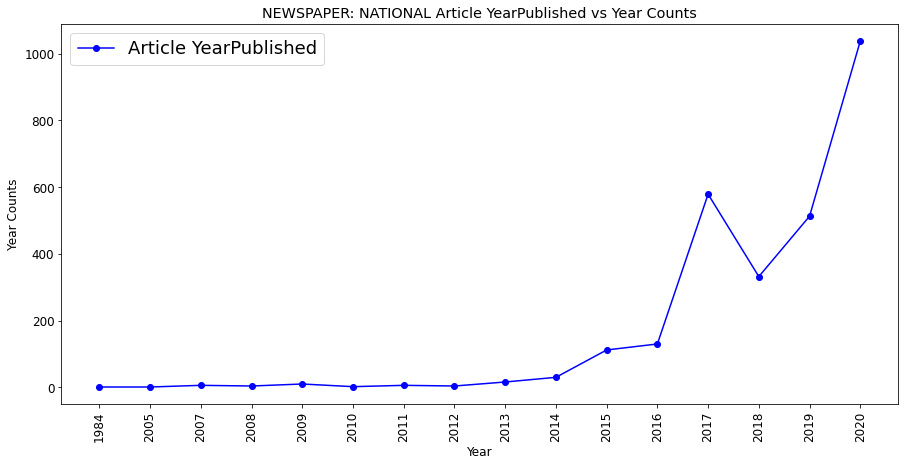

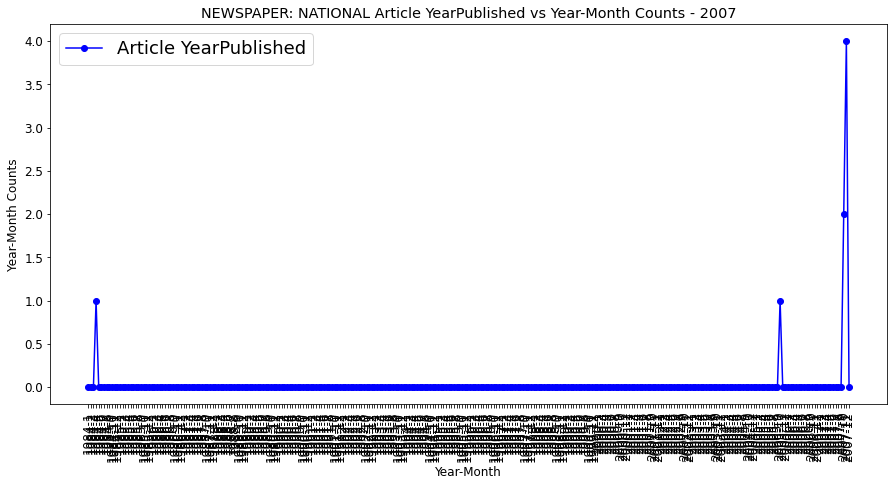

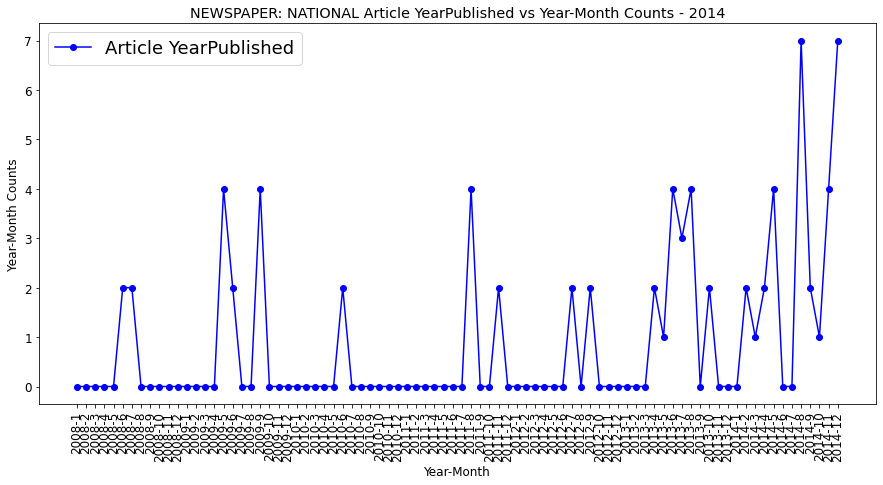

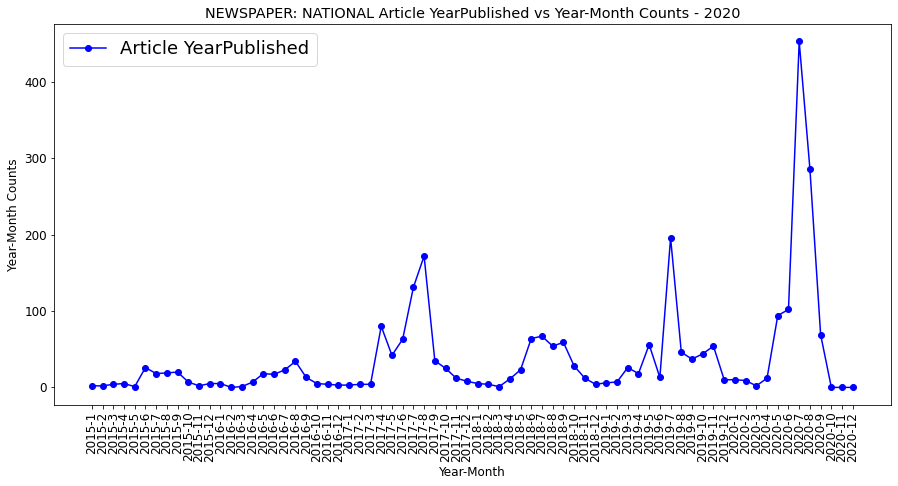

In [20]:
plot_year_yearmonth(get_newspaper_articles(df_data, national), 
                    'NEWSPAPER: NATIONAL', 'timeseries_data/national_newspaper.json')
